**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer to all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions as a single .zip file to the Site Pédagogique before the 5th of February 2020 (23h59). Name it as 'TP1-IMA205-YOUR-SURNAME.zip'.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [0]:

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
dest_path='./data/Data_FEI.npz')
gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
dest_path='./data/facial_landmarks_68markup.jpg')


Otherwise, you can also load them from your local machine using the following code

In [77]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

Let's load the Python packages containing the functions needed for the practical session.

In [0]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy import signal
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

We also load a user-defined function useful for plotting the confusion matrix

In [0]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark positions should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [80]:
# Parameters
dim=2 # dimension   
# Loading data
Working_directory="./data/" 
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

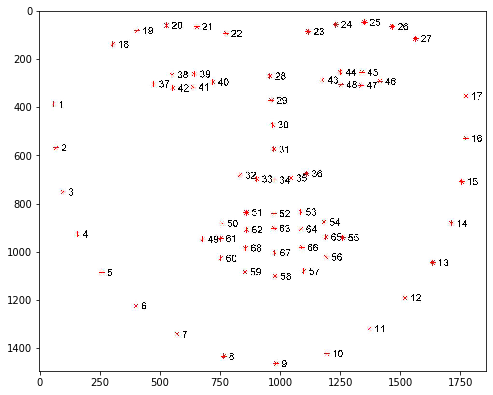

In [81]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

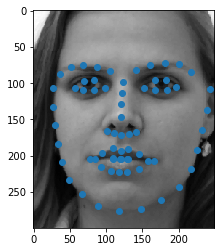

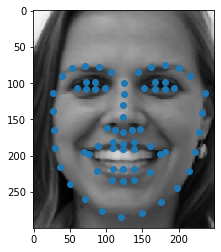

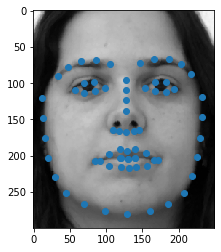

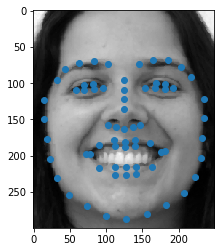

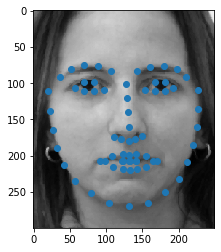

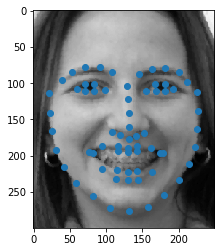

In [82]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?




---


On remarque que les landmarks définissent un pattern régulier correspondants à certains points caractéristiques du visage (contours du visage, lèvres, nez, sourcils...). On espère pouvoir détecter les visages souriants grâce à la forme de la bouche. 
Si on ne mélange pas les données, l'algorithme risque d'apprendre que une image sur deux correspond à une personne souriante, puisque les images sont alternées de manières régulières. Pour éviter ce biais, il est préférable de mélanger les données.


In [0]:
# Shuffle data randomly. Hint: Use np.random.shuffle
indices = np.arange(Images.shape[0])
np.random.shuffle(indices)

# Use as new variables
XpGPA=XGPA[indices]
Xp=X[indices]
Yp=Y[indices]
Imagesp=Images[indices]
Xmean = np.mean(XpGPA,axis=0) # Compute average
Namesp=Names[indices]



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. 

**Question**: Check them and compare them with the landmarks before alignement. Describe the differences.

In the following, we will use the landmarks after GPA (*XpGPA*)




---
Les landmark avant d'être alignés sont plus éparpillés, on observe notamment plus de différences entre les visages souriants et non-souriants. 


Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

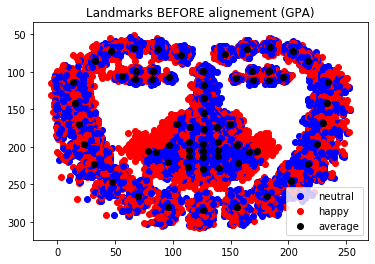

In [84]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

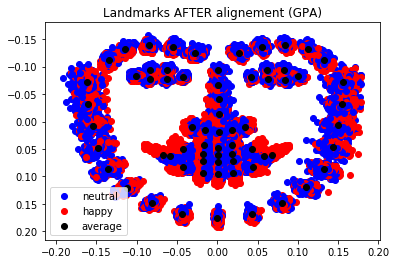

In [85]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the (aligned) landmarks of every subject and the landmarks of the average configuration. Please remember to use XpGPA.



---



In [0]:
# Compute distances from the average configuration (features)
def distance(landmark,av):
    x=landmark[::2]
    y=landmark[1::2]
    a=av[::2]
    b=av[1::2]
    return np.sqrt(((x-a)**2)+((y-b)**2))

dist_average=np.array([distance(XpGPA[i],Xmean)for i in range(len(XpGPA))])

---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

---

Scalariser ou normaliser les images est utile en machine learning pour donner le même poids à toutes les variables. En effet, si certains features sont compris entre 5000 et 1000 tandis que les autres sont entre 0 et 1, un poids très important va être donné à tord à la première feautre. 
Mais dans notre cas, toutes les features sont homogènes, ils ont été calculés de la même façon, comme la distance des landmark à une réference fixe. Ainsi les features plus grandes que les autres correspondent bien à un comportement extrème. La normalisation semble peu utile.

In [0]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
scaler.fit(dist_average)
dist_average_scale=scaler.transform(dist_average)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
dist_average_normalized=(dist_average-np.min(dist_average.flatten()))/(np.max(dist_average.flatten())-np.min(dist_average.flatten()))

Let's divide the data-set into Training and Test sets using original, scaled and normalized data.

In [0]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(dist_average_scale, np.ravel(Yp), test_size=0.33, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(dist_average_normalized, np.ravel(Yp), test_size=0.33, random_state=42)




---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

**Question**: Compare the performnces between original, scaled and normalized data. Comment the results.



---
 On choisit les même sets d'entrainement et de tests grâce à la précision "random_state=42", pour pouvoir vraiment comparer l'impact de la normalisation. Si on retirait cette précision nous obtiendrions des résultats différents car le modèle ne serait pas entraîné par les mêmes données. On obtient les même résultats pour tous les types de données (originales ou normalisées), car LDA cherche le minimum d'une fonction linéaire des données. Donc normaliser les données n'a pas d'impact, puisqu'il s'agit aussi d'une transformation linéaire, le minimum du discriminant sera toujours le même. 
 Dans les trois cas les résultats sont plutôt mauvais, peut être que certaines conditions comme la distribution normale ne sont pas remplies.


Fitting LDA to training set
done in 0.011s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

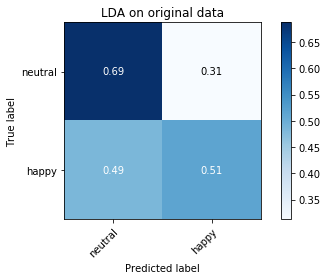

In [89]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
time_calcul=(time() - t0)
print("done in %0.3fs" % (time_calcul))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.title("LDA on original data")
plt.show()

done in 0.015s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


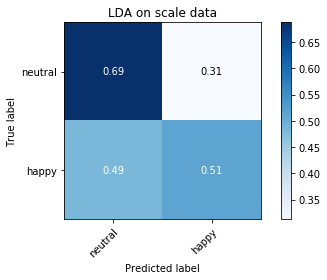

In [90]:
# Fitting LDA to scaled data
t0 = time()
lda_scale = LinearDiscriminantAnalysis()
lda_scale.fit(X_train_scale, y_train_scale)
y_pred_scale = lda_scale.predict(X_test_scale)
time_scale=(time() - t0)
print("done in %0.3fs" % (time_scale))
print(classification_report(y_test_scale, y_pred_scale))
cnf_matrix_scale = confusion_matrix(y_test_scale, y_pred_scale)
plot_confusion_matrix(cnf_matrix_scale, classes=class_names, normalize=True)
plt.title("LDA on scale data")
plt.show()

done in 0.016s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


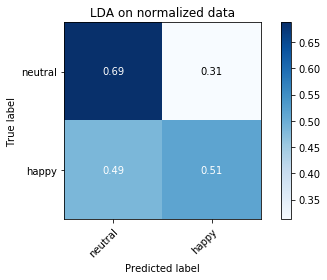

In [91]:
# Fitting LDA to normalized data
t0 = time()
lda_norm = LinearDiscriminantAnalysis()
lda_norm.fit(X_train_norm, y_train_norm)
y_pred_norm = lda_norm.predict(X_test_norm)
time_norm=(time() - t0)
print("done in %0.3fs" % (time_norm))
print(classification_report(y_test_norm, y_pred_norm))
cnf_matrix_norm = confusion_matrix(y_test_norm, y_pred_norm)
plot_confusion_matrix(cnf_matrix_norm, classes=class_names, normalize=True)
plt.title("LDA on normalized data")
plt.show()




---



We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

**Question**: compare the performances between original, scaled and normalized data



---
Nous avons vu dans la question précedente que LDA renvoyait les mêmes résultats pour les data originales, scalarisées ou normalisées. 
QDA est très proche de LDA, sauf que les matrices de covariance des variables sont considérées comme différentes. Mais dans notre étude, la position des landmark sur les visages étant très similaires d'une personne à l'autre, les matrices de covariances sont certainement presque égales. Ainsi, comme dans LDA, l'état des données n'importe pas. Il en est de même pour Naive Bayes, qui est encore un cas particulier de QDA qui considère les matrices de covariance comme diagonales. 

Logistic regression n'obtient pas les mêmes résultats selon le format des données. En effet, Logistic regression associe un point à une classe selon le signe d'une fonction linéaire dépendant des data. Ainsi, quand on soustrait ou additionne une constantes aux données, on risque de changer le signe du discriminant , ce qui change  notre classification. On observe bien que les resultats sont différents, de même, pour les données scalarisées le temps de calcul est anormalement long.  Les résultats sont un peu meilleurs pour les données normalisées que pour les donées originales. 

Enfin, l'algorithme des K voisins n'est pas censé renvoyer des résultats similaires pour tous les types de data, car la distance euclidienne n'est pas linéaire. On obtient le même résultat entre les data originales et celles normalisées car le minimum de distance_average est très petit. Scale obtient de moins bon résultats que les deux autres méthodes.

In [92]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.053s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.041s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.029s
 Average and std CV score : 0.5349999999999999 +- 0.0483476990145343
Fitting Naive-Bayes
done in 0.012s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.066s
 Average and std CV score : 0.6049999999999999 +- 0.032210246816812824


In [93]:
# Cross-validation for Scale Data

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda_scale = LinearDiscriminantAnalysis()
lda_score_scale = cross_val_score(lda_scale,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score_scale.mean(), lda_score_scale.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda_scale = QuadraticDiscriminantAnalysis()
qda_score_scale = cross_val_score(qda_scale,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score_scale.mean(), qda_score_scale.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit_scale = LogisticRegression(solver='lbfgs')
logit_score_scale = cross_val_score(logit_scale,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score_scale.mean(), logit_score_scale.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB_scale = GaussianNB()
GNB_score_scale = cross_val_score(GNB_scale,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score_scale.mean(), GNB_score_scale.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh_scale = KNeighborsClassifier(n_neighbors=3)
neigh_score_scale = cross_val_score(neigh_scale,X=dist_average_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score_scale.mean(), neigh_score_scale.std() ))

Fitting LDA
done in 0.053s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.042s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.193s
 Average and std CV score : 0.55 +- 0.01767766952966367
Fitting Naive-Bayes
done in 0.012s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.066s
 Average and std CV score : 0.5625 +- 0.017677669529663688


In [94]:
# Cross-validation for normalized Data

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda_norm = LinearDiscriminantAnalysis()
lda_score_norm = cross_val_score(lda_norm,X=dist_average_normalized, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score_norm.mean(), lda_score_norm.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda_norm = QuadraticDiscriminantAnalysis()
qda_score_norm = cross_val_score(qda_norm,X=dist_average_normalized, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score_norm.mean(), qda_score_norm.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit_norm = LogisticRegression(solver='lbfgs')
logit_score_norm = cross_val_score(logit_norm,X=dist_average_normalized, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score_norm.mean(), logit_score_norm.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB_norm = GaussianNB()
GNB_score_norm = cross_val_score(GNB_norm,X=dist_average_normalized, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score_norm.mean(), GNB_score_norm.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh_norm = KNeighborsClassifier(n_neighbors=3)
neigh_score_norm = cross_val_score(neigh_norm,X=dist_average_normalized, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score_norm.mean(), neigh_score_norm.std() ))

Fitting LDA
done in 0.051s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.062s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.065s
 Average and std CV score : 0.57 +- 0.03020761493398643
Fitting Naive-Bayes
done in 0.011s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.065s
 Average and std CV score : 0.6049999999999999 +- 0.032210246816812824


Les deux matrices sont toutes deux presque égales à zéro, elles sont presques égales, ce qui correspond bien à l'hypothèse réalisée pour justifier les résultats de QDA.

In [95]:

X_sourire=(np.array([XGPA[2*i+1]for i in range(len(Images)//2)]))
X_normal=(np.array([XGPA[2*i]for i in range(len(Images)//2)]))
dist_average_sourire=np.array([distance(X_sourire[i],Xmean)for i in range(len(XGPA)//2)])
dist_average_normal=np.array([distance(X_normal[i],Xmean)for i in range(len(XGPA)//2)])
cov_sourire=np.cov(dist_average_sourire)
cov_normal=np.cov(dist_average_normal)
print('Maximum de la matrice de covariance de la classe sourire :' + str(np.max(cov_sourire.flatten())))
print('Maximum de la matrice de covariance de la classe sans sourire :' + str(np.max(cov_normal.flatten())))

Maximum de la matrice de covariance de la classe sourire :6.292217296096551e-05
Maximum de la matrice de covariance de la classe sans sourire :6.632298586437418e-05




---



In the previous example we have fixed the hyper-parameter K to 3. We coudl use CV to find the best value.



---



The best K is 7  with an average validation score equal to  0.6399999999999999


Text(0, 0.5, 'CV Validation Score')

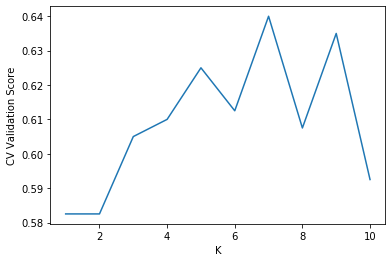

In [96]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 5  with an average validation score equal to  0.6044025157232704
The test score is 0.6590909090909091


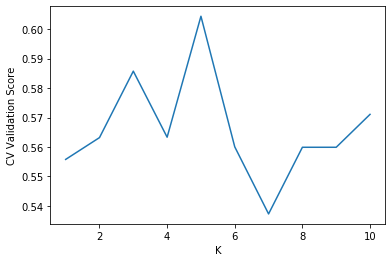

In [97]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))



---



**Question**: Comment the results of the two previosu experiments. What about the best K and validation error ? Are the results the same ? Why in your opinion ?



---
La première méthode choisit la valeur de K en se basant sur toutes les données, tandis que la seconde méthode ne se base que sur les données du training set.
Il semble que la meilleure valeur de K soit égale à 7, car le score de validation est plus grand. Cependant, génerallement il est déconseillé de se baser sur toutes les données pour définir notre modèle, car la validation perd tout son intérêt. En effet, si l'on se base sur toutes les données, et qu'on réalise ensuite un test avec l'une de ces données, le résultat du test est biaisé. Si le modèle a été entraîné sur une donnée, il s'agit d'un cas facile pour lui, car il connaît déjà cette donnée. 
L'intérêt d'avoir un training set séparé est de tester l'efficacité de la classification sans biais.




---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [0]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))
def distance_combination(landmark):
  dist=[]
  for i in range(0,2*M,2):
    for j in range(0,i,2):
      dist.append(np.sqrt((landmark[i]-landmark[j])**2+(landmark[i+1]-landmark[j+1])**2))
  return dist
dist_combination=np.array([distance_combination(XpGPA[i])for i in range(len(XpGPA))])

**Question**: As before, should we scale/normalize the data ?

In [0]:
scaler = StandardScaler()
scaler.fit(dist_combination)
dist_combination_scale=scaler.transform(dist_combination)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
dist_combination_norm=(dist_combination-np.min(dist_combination.flatten()))/(np.max(dist_combination.flatten())-np.min(dist_combination.flatten()))

Cette fois la normalisation est utile car tous les features n'auront pas les mêmes intervalles de valeurs : par exemple, la feature correspondant à la distance entre un point des sourcils et un point de la bouche sera toujours bien plus grand que celle entre deux points du nez. Comme l'on souhaite que chaque feature aie le même poids, il est nécessaire de normaliser.

**Question**: Use the classification algorithms seen before to test the discriminative power of the new features. 

Globalement, les nouvelles variables permettent d'obtenir de meilleurs résultats, cependant, les temps de calcul sont multipliés par dix, car il y a beaucoup plus de variables.

In [100]:
# Fitting LDA to original data
print("Fitting LDA to orginal data")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))
# Fitting LDA to scale data
print("Fitting LDA to scale data")
t0 = time()
lda_scale = LinearDiscriminantAnalysis()
lda_score_scale= cross_val_score(lda_scale,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score_scale.mean(), lda_score_scale.std() ))
# Fitting LDA to normalized data
print("Fitting LDA to normalized data")
t0 = time()
lda_norm = LinearDiscriminantAnalysis()
lda_score_norm = cross_val_score(lda_norm,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score_norm.mean(), lda_score_norm.std() ))


Fitting LDA to orginal data
done in 1.588s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting LDA to scale data
done in 1.614s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257
Fitting LDA to normalized data
done in 1.609s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257


Nous pouvons observer que les résultats sur LDA sont encore une fois tous égaux grâce aux propriétés de LDA. 

In [101]:
# Fitting QDA to original data
print("Fitting QDA to orginal data")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))
# Fitting QDA to scale data
print("Fitting QDA to scale data")
t0 = time()
qda_scale = QuadraticDiscriminantAnalysis()
qda_score_scale= cross_val_score(qda_scale,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score_scale.mean(), qda_score_scale.std() ))
# Fitting QDA to normalized data
print("Fitting QDA to normalized data")
t0 = time()
qda_norm = QuadraticDiscriminantAnalysis()
qda_score_norm = cross_val_score(lda_norm,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score_norm.mean(), qda_score_norm.std() ))

Fitting QDA to orginal data


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.828s
 Average and std CV score : 0.6224999999999999 +- 0.06244997998398399
Fitting QDA to scale data


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.847s
 Average and std CV score : 0.6275000000000001 +- 0.09400797838481582
Fitting QDA to normalized data
done in 1.607s
 Average and std CV score : 0.9174999999999999 +- 0.023184046238739257


Il semblerait que certaines variables soient colinéaires. 
De plus on obtient des résultats différents pour QDA cette fois.
Le résultat normalisé est bien meilleur que les deux autres, mais le temps de calcul est aussi beaucoup plus long. 
En effet, on peut voir que les matrices de covariances ne peuvent pas êtres considérées comme égales:


In [102]:
X_sourire=(np.array([XGPA[2*i+1]for i in range(len(Images)//2)]))
X_normal=(np.array([XGPA[2*i]for i in range(len(Images)//2)]))
dist_average_sourire=np.array([distance_combination(X_sourire[i])for i in range(len(XGPA)//2)])
dist_average_normal=np.array([distance_combination(X_normal[i])for i in range(len(XGPA)//2)])
cov_sourire=np.cov(dist_average_sourire)
cov_normal=np.cov(dist_average_normal)
Difference=np.abs(cov_sourire-cov_normal)
print('Maximum de la matrice de covariance de la classe sourire :' + str(np.max(cov_sourire.flatten())))
print('Maximum de la matrice de covariance de la classe sans sourire :' + str(np.max(cov_normal.flatten())))
print('Maximum de la différence entre les deux:'+str(np.max(Difference.flatten())))

Maximum de la matrice de covariance de la classe sourire :0.005996336018138127
Maximum de la matrice de covariance de la classe sans sourire :0.006147572902305849
Maximum de la différence entre les deux:0.0004377419222078337


In [103]:
# Fitting Logistic-regression with original data
print("Fitting Logistic Regression to original data")
t0 = time()
logit= LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))
# Fitting Logistic-regression with scale data
print("Fitting Logistic Regression to scale data")
t0 = time()
logit_scale = LogisticRegression(solver='lbfgs')
logit_score_scale = cross_val_score(logit_scale,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score_scale.mean(), logit_score_scale.std() ))
# Fitting Logistic-regression with normalized data
print("Fitting Logistic Regression to normalized data")
t0 = time()
logit_norm = LogisticRegression(solver='lbfgs')
logit_score_norm = cross_val_score(logit_norm,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score_norm.mean(), logit_score_norm.std() ))

Fitting Logistic Regression to original data
done in 0.338s
 Average and std CV score : 0.9475 +- 0.019999999999999976
Fitting Logistic Regression to scale data
done in 0.659s
 Average and std CV score : 0.9625 +- 0.0262202212042538
Fitting Logistic Regression to normalized data
done in 0.552s
 Average and std CV score : 0.9650000000000001 +- 0.022912878474779203


Les données scalarisées et normalisées obtiennent de meilleurs résultats sur logisitc regression, mais le temps de calcul est aussi plus long qu'avec les données originales. C'est aussi la méthode permettant d'obtenir les meilleurs résultats.

In [104]:
# Fitting Naive-Bayes to original data
print("Fitting Naive-Bayes to original data")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))
# Fitting Naive-Bayes to scale data
print("Fitting Naive-Bayes to scale data")
t0 = time()
GNB_scale = GaussianNB()
GNB_score_scale = cross_val_score(GNB_scale,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score_scale.mean(), GNB_score_scale.std() ))
# Fitting Naive-Bayes to normalized data
print("Fitting Naive-Bayes to normalized data")
t0 = time()
GNB_norm = GaussianNB()
GNB_score_norm = cross_val_score(GNB_norm,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score_norm.mean(), GNB_score_norm.std() ))


Fitting Naive-Bayes to original data
done in 0.089s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting Naive-Bayes to scale data
done in 0.067s
 Average and std CV score : 0.9475 +- 0.031024184114977156
Fitting Naive-Bayes to normalized data
done in 0.073s
 Average and std CV score : 0.9475 +- 0.031024184114977156


Les matrices de covariances ne sont pas diagonales, les résultats de Naive Bayes sont donc erronés.

In [105]:
# Fitting K-nearest neighbour to original data
print("Fitting K-nearest neighbour to original data")
t0 = time()
neigh= KNeighborsClassifier(n_neighbors=3)
neigh_score= cross_val_score(neigh,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))
# Fitting K-nearest neighbour to scale data
print("Fitting K-nearest neighbour to scale data")
t0 = time()
neigh_scale = KNeighborsClassifier(n_neighbors=3)
neigh_score_scale = cross_val_score(neigh_norm,X=dist_combination_scale, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score_scale.mean(), neigh_score_scale.std() ))
# Fitting K-nearest neighbour to normalized data
print("Fitting K-nearest neighbour to normalized data")
t0 = time()
neigh_norm = KNeighborsClassifier(n_neighbors=3)
neigh_score_norm = cross_val_score(neigh_norm,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score_norm.mean(), neigh_score_norm.std() ))

Fitting K-nearest neighbour to original data
done in 0.850s
 Average and std CV score : 0.9425000000000001 +- 0.024494897427831803
Fitting K-nearest neighbour to scale data
done in 0.843s
 Average and std CV score : 0.9225 +- 0.03482097069296032
Fitting K-nearest neighbour to normalized data
done in 0.803s
 Average and std CV score : 0.9425000000000001 +- 0.024494897427831803


Une fois encore on observe que Kvoisins renvoie le même résultat pour la data originale et normalisée mais pas pour les données scalarisées . 



---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. We could use a very well-known technique called PCA (Principal Component Analysis). We will see it in few lectures...



---



In [106]:
# We could use PCA to map the data to a new coordiante system where the new variables would be orthogonal among each other. (so no more collinear...)
pca = decomposition.PCA(n_components=0.9) # use number of components take explain 90% of variability
pca.fit(dist_combination)
dist_combination_pca = pca.transform(dist_combination)  

print('Number of subjects N is: ', dist_combination_pca.shape[0], ' ; number of features is: ',  dist_combination_pca.shape[1] )
dist_combination_pca_norm=(dist_combination_pca-min(dist_combination_pca.flatten()))/(max(dist_combination_pca.flatten())-min(dist_combination_pca.flatten()))

Number of subjects N is:  400  ; number of features is:  8


**Question**: Test the predictive power of the new features


In [107]:
# Fitting Logistic-regression with original data
print("Fitting Logistic Regression to original data")
t0 = time()
logit= LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))


Fitting Logistic Regression to original data
done in 0.040s
 Average and std CV score : 0.9475 +- 0.019999999999999976


In [108]:
# Fitting LDA to original data
print("Fitting LDA to orginal data")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

Fitting LDA to orginal data
done in 0.023s
 Average and std CV score : 0.9525 +- 0.024238399287081668


In [109]:
# Fitting QDA to original data
print("Fitting QDA to orginal data")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

Fitting QDA to orginal data
done in 0.014s
 Average and std CV score : 0.97 +- 0.032210246816812824


In [110]:
# Fitting Naive-Bayes to original data
print("Fitting Naive-Bayes to original data")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_combination, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

Fitting Naive-Bayes to original data
done in 0.079s
 Average and std CV score : 0.9475 +- 0.031024184114977156


In [111]:
# Fitting K-nearest neighbour to original data
print("Fitting K-nearest neighbour to original data")
t0 = time()
neigh= KNeighborsClassifier(n_neighbors=3)
neigh_score= cross_val_score(neigh,X=dist_combination_pca, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))


Fitting K-nearest neighbour to original data
done in 0.031s
 Average and std CV score : 0.945 +- 0.023184046238739254


Le PCA permet d'améliorer considérablement les temps de calcul, car il y a beacuoup moins de données à traiter. Sur certaines méthode, le PCA permet aussi d'améliorer le résultat, comme sur le QDA. QCA est la méthode avec le plus petit temps de calcul et le mailleur résultat obtenu pour l'instant. Au contraire pour d'autres méthodes comme Naive Bayes ou Logistic regression, le PCA ne change pas le résultat.



---


A second solution, would be to manually select few landmarks



---



In [112]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56,63,64,67,66,62,68,44,45,48,47,38,39,42,41,32,36]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  44


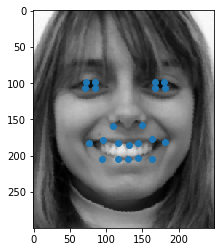

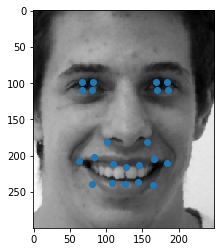

In [113]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

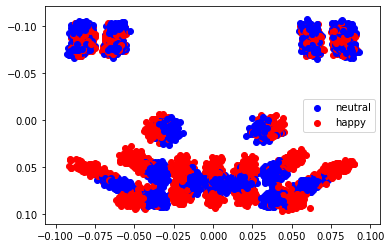

In [114]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [115]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.97875 +- 0.00459279326771844
 Average and std test score : 0.95 +- 0.022360679774997907


---

Let's plot some images where the best model was wrong. 

**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks

---

En premier lieu, l'algorithme commet des erreurs sur les personnes n'étirant pas beaucoup la bouche en souriant. J'ai donc decidé de rajouter l'ouverture de labouche dans les landmarks. Cependant, certaines personnes sourient sans ouvrir la bouche. J'ai essayé avec le bord du nez, et le coin exterieur des yeux, ou encore l'ouverture des yeux, sans succès.

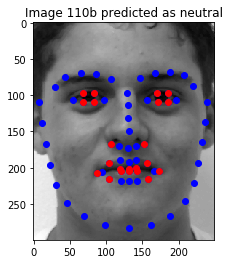

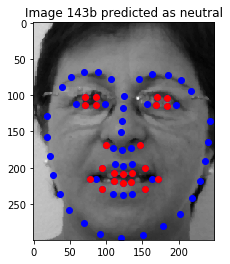

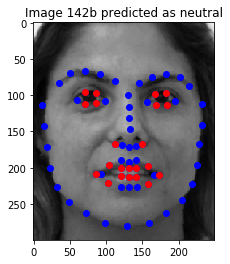

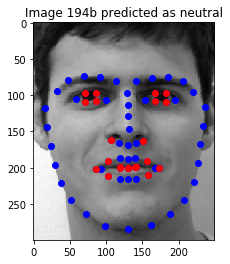

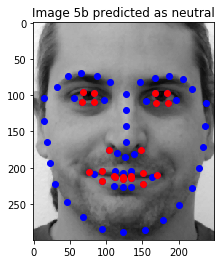

In [116]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 




---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [117]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 1.816s
Average and std Nested Cv train score : 0.9775 +- 0.0030618621784789485
Average and std Nested Cv test score : 0.9675 +- 0.01695582495781321


---

**Question**: Are Training and Test scores similar ? What does it mean ?

---
Le train score est légèrement plus élevé que le test score.
Cela signifie que les deux sets n'ont pas exactement la même distribution, et l'algorithme a été entraîné sur la distribution du set de test. Ce phénomène s'appelle overfitting, cela signifie que notre approximation est trop sensible aux données.

**Question**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power

Cherchons de nouveaux paramètres utiles pour détecter si une personne est entrain de sourire ou non.

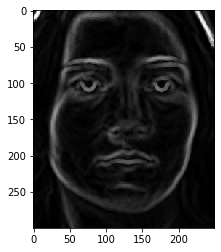

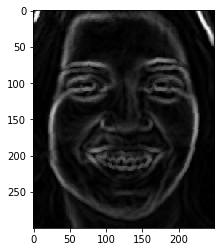

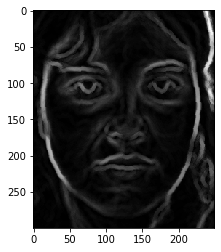

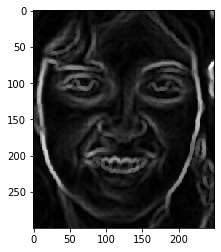

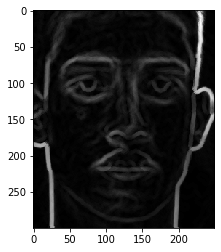

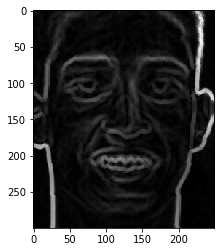

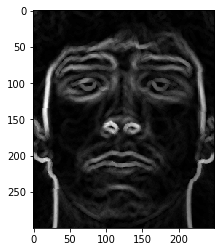

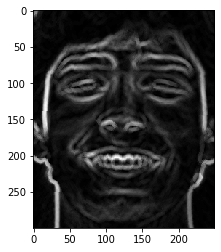

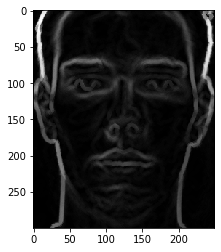

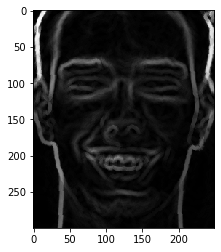

In [118]:
Gx=[[-1,0,1],[-2,0,2],[-1,0,1]]
Gy=[[-1,-2,-1],[0,0,0],[-1,-2,-1]]
import skimage.morphology as morpho
from skimage.color import rgb2gray
def strel(forme, taille,angle = 45):
    if forme == 'diamond' : 
        return morpho.selem.diamond(taille)
    if forme == 'disk' : 
        return morpho.selem.disk(taille)
    if forme == 'square' : 
        return morpho.selem.square(taille)
    if forme == 'line' : 
        angle = int(-np.round(angle))
        angle = angle%180
        angle = np.float32(angle)/180.0*np.pi
        x = int(np.round(np.cos(angle)*taille))
        y = int(np.round(np.sin(angle)*taille))
        if x**2 + y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x = int(np.sign(np.cos(angle)))
                y = 0
            else:
                y = int(np.sign(np.sin(angle)))
                x = 0
        rr, cc = morpho.selem.draw.line(0, 0, y, x)
        rr = rr-rr.min()
        cc = cc-cc.min()
        img = np.zeros((r.max()+1, cc.max()+1))
        img[rr,cc] = 1
        returnimg
        
    raise RuntimeError('Erreur dans fonction strel : forme incomprise.')
def filtrer_grad_morpho(image):
    element = strel("disk", np.floor(3))
    image = morpho.closing(morpho.opening(image,element),element)
    elmt=strel("disk",np.floor(3))
    grad=morpho.dilation(image,elmt)-morpho.erosion(image,elmt)
    return grad

for i in range(10,20):
  plt.imshow(filtrer_grad_morpho(rgb2gray(Images[i,:,:])),cmap='gray')
  plt.show()

Il semble que le contour des dents soit un bon critère : 

Moyenne des pixels sur la zone observée:17.4552


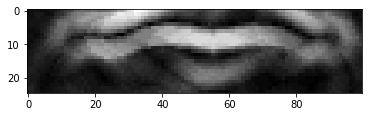

Moyenne des pixels sur la zone observée:24.0052


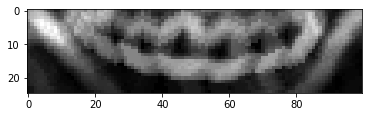

Moyenne des pixels sur la zone observée:19.0296


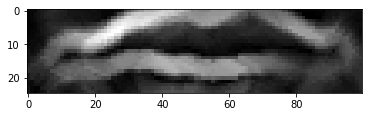

Moyenne des pixels sur la zone observée:24.9804


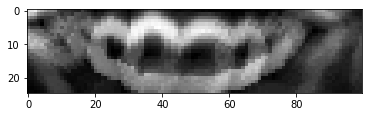

Moyenne des pixels sur la zone observée:13.0144


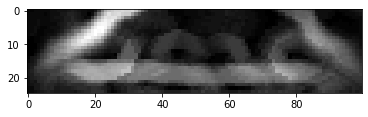

Moyenne des pixels sur la zone observée:23.4472


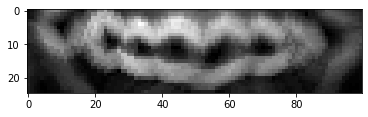

Moyenne des pixels sur la zone observée:16.2728


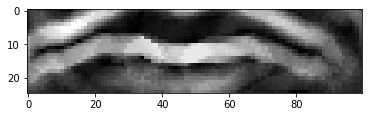

Moyenne des pixels sur la zone observée:27.7404


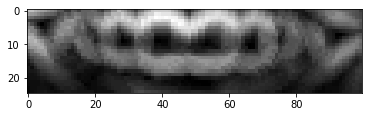

Moyenne des pixels sur la zone observée:13.7432


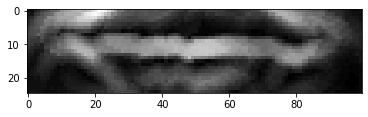

Moyenne des pixels sur la zone observée:22.2308


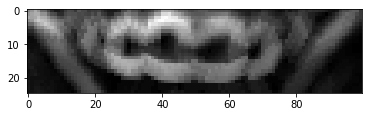

In [119]:
def moyenne_sourire(img,show=False):
  im=filtrer_grad_morpho(rgb2gray(img))
  moy=np.mean(im[200:225,75:175])
  if show:
    print("Moyenne des pixels sur la zone observée:"+str(moy))
    plt.imshow(im[200:225,75:175],cmap='gray')
    plt.show()
  return moy

for i in range(10,20):
  moyenne_sourire(Images[i,:,:],show=True)

On observe bien que la moyenne de couleur est différente, ajoutons ce feature une fois normalisé à dist_combination :

In [0]:
dents=[]
for i in range(len(Images)):
  dents.append(moyenne_sourire(Images[i,:,:]))

#on normalise cette nouvelle feature
dents_norm=(dents-min(dents))/(max(dents)-min(dents))

In [0]:
dist_combination_bis=np.zeros((N,int((M*(M-1)/2))))
def distance_combination_bis(landmark,index):
  dist=[]
  for i in range(0,2*M,2):
    for j in range(0,i,2):
      dist.append(np.sqrt((landmark[i]-landmark[j])**2+(landmark[i+1]-landmark[j+1])**2))
  dist.append(dents_norm[index])
  return dist
dist_combination_bis=np.array([distance_combination_bis(XpGPA[i],i)for i in range(len(XpGPA))])

In [0]:
pca = decomposition.PCA(n_components=0.9) # use number of components take explain 90% of variability
pca.fit(dist_combination_bis)
dist_combination_pca_bis = pca.transform(dist_combination_bis)

In [125]:

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination_pca_bis, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

Fitting QDA
done in 0.019s
 Average and std CV score : 0.9675 +- 0.03674234614174766


En utilisant la cross validation et le QCA, sur lequel on a obtenu de très bons résultats avec le PCA, on obtient un bon score, bien qu'il soit légèrement plus faible qu'avant notre modification.